# Summary
### Feature Engineer:
1. 构造了所有categorical variable的**count 特征**（count for every unique value)
2. 用前一天的数据构造了**点击率**与**曝光数**特征
3. 基于部分特征构造了**二阶统计特征**

### Memory Reduction:
1. 将数据转化成不同的格式
2. 注意删除不再使用的变量

Results: Logloss 0.3907; Ranking 158th; Public board Top10% (late submission)

In [1]:
import pandas as pd
import numpy as  np
from matplotlib import pyplot as plt
import seaborn as sns
import json
import datetime
from sklearn import preprocessing
sns.set()

import joblib
import gc

# 1. Load the data

In [2]:
num_of_chunk = 0
chunksize = 10 ** 6

train = pd.DataFrame()
train_path = "train.gz"
test_path = "test.gz"

for chunk in pd.read_csv(train_path, sep = ",", chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=.01, replace=False, random_state=123)], axis=0) # >= chunk.sample(frac = .002)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

# Create a back-up file for the length of the training set
train_len = len(train)
train_len

Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3
Processing Chunk No. 4
Processing Chunk No. 5
Processing Chunk No. 6
Processing Chunk No. 7
Processing Chunk No. 8
Processing Chunk No. 9
Processing Chunk No. 10
Processing Chunk No. 11
Processing Chunk No. 12
Processing Chunk No. 13
Processing Chunk No. 14
Processing Chunk No. 15
Processing Chunk No. 16
Processing Chunk No. 17
Processing Chunk No. 18
Processing Chunk No. 19
Processing Chunk No. 20
Processing Chunk No. 21
Processing Chunk No. 22
Processing Chunk No. 23
Processing Chunk No. 24
Processing Chunk No. 25
Processing Chunk No. 26
Processing Chunk No. 27
Processing Chunk No. 28
Processing Chunk No. 29
Processing Chunk No. 30
Processing Chunk No. 31
Processing Chunk No. 32
Processing Chunk No. 33
Processing Chunk No. 34
Processing Chunk No. 35
Processing Chunk No. 36
Processing Chunk No. 37
Processing Chunk No. 38
Processing Chunk No. 39
Processing Chunk No. 40
Processing Chunk No. 41


404290

In [3]:
test = pd.read_csv(test_path, sep = ",", delimiter=',',dtype={'id': str})
data = pd.concat([train,test],sort= False)

In [4]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df

In [5]:
data.memory_usage()

Index               39854032
index               39854032
id                  39854032
click               39854032
hour                39854032
C1                  39854032
banner_pos          39854032
site_id             39854032
site_domain         39854032
site_category       39854032
app_id              39854032
app_domain          39854032
app_category        39854032
device_id           39854032
device_ip           39854032
device_model        39854032
device_type         39854032
device_conn_type    39854032
C14                 39854032
C15                 39854032
C16                 39854032
C17                 39854032
C18                 39854032
C19                 39854032
C20                 39854032
C21                 39854032
dtype: int64

In [6]:
data = reduce_mem(data)

988.20 Mb, 570.12 Mb (42.31 %)


In [7]:
data.head()

,index,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,373315.0,2.75475e+18,1.0,14102102,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,1,0,17753,320,50,1993,2,1063,-1,33
1,459286.0,9.6308e+18,0.0,14102102,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15699,320,50,1722,0,35,100083,79
2,262398.0,1.04823e+19,0.0,14102102,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15703,320,50,1722,0,35,100083,79
3,789396.0,1.83086e+19,0.0,14102104,1005,1,b8eae5f9,1e334bd3,f028772b,ecad2386,...,1,0,19950,320,50,1800,3,167,100077,23
4,383229.0,3.55939e+18,0.0,14102102,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15701,320,50,1722,0,35,-1,79


# 2. Data Processing
Use only date > 27 to fit the model

In [8]:
# get the data
def get_date(x):
    return str(x)[4:6]
data['day'] = data['hour'].apply(get_date)
data['day'] = data['day'].astype(int)

In [9]:
data = data[data['day']>=27]

In [10]:
del data['id'],data['index']

# 3. Feature Engineering

### 3-1. Count features for every categorical variable

In [11]:
# Generate user identifier
data['user'] = data['device_id'].astype(str) + '-'  + data['device_model'].astype(str)+'-'+ data['device_ip'].astype(str)

In [12]:
cate_fea = ['user','device_id','C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C18', 'C19', 'C20', 'C21']
for f in cate_fea:
    # generate a dictionary for each unique value, associated with its Id
    map_dict = dict(zip(data[f].unique(), range(data[f].nunique())))
    # transform each categorical variable using label encoding (1,2,3,4...)
    data[f] = data[f].map(map_dict).fillna(-1).astype('int32')
    # generate the count feature
    data[f + '_count'] = data[f].map(data[f].value_counts())
    data = reduce_mem(data)

578.98 Mb, 520.18 Mb (10.16 %)
538.27 Mb, 520.18 Mb (3.36 %)
565.41 Mb, 533.75 Mb (5.60 %)
583.51 Mb, 551.84 Mb (5.43 %)
569.94 Mb, 542.80 Mb (4.76 %)
560.89 Mb, 533.75 Mb (4.84 %)
551.84 Mb, 520.18 Mb (5.74 %)
538.27 Mb, 511.14 Mb (5.04 %)
529.23 Mb, 502.09 Mb (5.13 %)
520.18 Mb, 488.52 Mb (6.09 %)
506.61 Mb, 488.52 Mb (3.57 %)
506.61 Mb, 479.47 Mb (5.36 %)
497.57 Mb, 470.43 Mb (5.45 %)
520.18 Mb, 488.52 Mb (6.09 %)
538.27 Mb, 506.61 Mb (5.88 %)
551.84 Mb, 524.71 Mb (4.92 %)
569.94 Mb, 538.27 Mb (5.56 %)
583.51 Mb, 551.84 Mb (5.43 %)
601.60 Mb, 569.94 Mb (5.26 %)
615.17 Mb, 583.51 Mb (5.15 %)
619.69 Mb, 592.55 Mb (4.38 %)
637.79 Mb, 606.12 Mb (4.96 %)


Delete unused columns

In [13]:
for f in ['hour','device_ip','C17']:
    del data[f]

In [14]:
data = data.reset_index(drop = True)
data['id'] = data.index + 1
click_df = data[data['click'] == 1]

In [15]:
data.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_type_count,device_conn_type_count,C14_count,C15_count,C16_count,C18_count,C19_count,C20_count,C21_count,id
0,1.0,0,0,0,0,0,0,0,0,0,...,177785,3999217,601,4448900,4493010,2191173,57540,134675,2670,1
1,0.0,1,0,1,1,1,1,0,0,1,...,4494095,3999217,70,4448900,4493010,964735,262233,2208817,1036561,2
2,0.0,2,1,2,2,2,1,0,0,1,...,4494095,3999217,549,4448900,4493010,1343348,888328,2208817,1036561,3
3,0.0,2,0,3,3,3,1,0,0,1,...,4494095,3999217,4121,4448900,4493010,1343348,888328,45303,1036561,4
4,0.0,0,0,4,0,0,1,0,0,2,...,177785,3999217,5403,4448900,4493010,1343348,8486,117012,5927,5


In [16]:
for f in [
    ['user'],
    ['banner_pos', 'user'],
    ['C21', 'user'],
    # ...
]:
    print('------------------ {} ------------------'.format('_'.join(f)))
    
    # 对前一天的点击次数进行统计
    tmp = click_df[f + ['day', 'id']].groupby(f + ['day'], as_index=False)['id'].agg({'_'.join(f) + '_prev_day_click_count': 'count'})
    tmp['day'] += 1 # make the above calculated count correspond to previous day
    data = data.merge(tmp, on=f + ['day'], how='left')
    data['_'.join(f) + '_prev_day_click_count'] = data['_'.join(f) + '_prev_day_click_count'].fillna(0) # deal with NA in the first day
    data.loc[data['day'] == 27, '_'.join(f) + '_prev_day_click_count'] = None
    
    # 对前一天的曝光量进行统计
    tmp = data[f + ['day', 'id']].groupby(f + ['day'], as_index=False)['id'].agg({'_'.join(f) + '_prev_day_count': 'count'})
    tmp['day'] += 1
    data = data.merge(tmp, on=f + ['day'], how='left')
    data['_'.join(f) + '_prev_day_count'] = data['_'.join(f) + '_prev_day_count'].fillna(0)
    data.loc[data['day'] == 27, '_'.join(f) + '_prev_day_count'] = None
    
    # 计算前一天的点击率
    data['_'.join(f) + '_prev_day_ctr'] = data['_'.join(f) + '_prev_day_click_count'] / (
            data['_'.join(f) + '_prev_day_count'] + data['_'.join(f) + '_prev_day_count'].mean())

    del tmp

del click_df

data = reduce_mem(data)

------------------ user ------------------
------------------ banner_pos_user ------------------
------------------ C21_user ------------------
922.76 Mb, 660.40 Mb (28.43 %)


In [17]:
cols = ["user_prev_day_click_count", 
        "user_prev_day_count",
        "user_prev_day_ctr", 
        "banner_pos_user_prev_day_click_count", 
        "banner_pos_user_prev_day_count", 
        "banner_pos_user_prev_day_ctr", "C21_user_prev_day_click_count", "C21_user_prev_day_count", "C21_user_prev_day_ctr"]
data[cols].describe()

,user_prev_day_click_count,user_prev_day_count,user_prev_day_ctr,banner_pos_user_prev_day_click_count,banner_pos_user_prev_day_count,banner_pos_user_prev_day_ctr,C21_user_prev_day_click_count,C21_user_prev_day_count,C21_user_prev_day_ctr
count,4710812.0,4710812.0,4.710812e+06,4710812.0,4710812.0,4.710812e+06,4710812.0,4710812.0,4.710812e+06
mean,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00
std,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
min,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
25%,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
50%,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
75%,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
max,10.0,69.0,9.580078e-01,10.0,65.0,9.858398e-01,10.0,68.0,9.633789e-01


In [18]:
data  = data.reset_index(drop = True)
data['index'] = data.index +1

from scipy.stats import entropy
print('*************************** cross feat (second order) ***************************')
# 二阶交叉特征，可以继续做更高阶的交叉。
# Why not use device type
cross_cols = ['device_model','app_id','site_id','site_domain','banner_pos']
for f in cross_cols:
    for col in cross_cols:
        if col == f:
            # The continue statement directly continues to loop without running the remaining code
            continue
        print('------------------ {} {} ------------------'.format(f, col))
        data = data.merge(data[[f, col]].groupby(f, as_index=False)[col].agg({
            'cross_{}_{}_nunique'.format(f, col): 'nunique',
            'cross_{}_{}_ent'.format(f, col): lambda x: entropy(x.value_counts() / x.shape[0]) # 熵
        }), on=f, how='left')
        if 'cross_{}_{}_count'.format(f, col) not in data.columns.values and 'cross_{}_{}_count'.format(col, f) not in data.columns.values:
            data = data.merge(data[[f, col, 'index']].groupby([f, col], as_index=False)['index'].agg({
                'cross_{}_{}_count'.format(f, col): 'count' # 共现次数
            }), on=[f, col], how='left')
        if 'cross_{}_{}_count_ratio'.format(col, f) not in data.columns.values:
            data['cross_{}_{}_count_ratio'.format(col, f)] = data['cross_{}_{}_count'.format(f, col)] / data[f + '_count'] # 比例偏好
        if 'cross_{}_{}_count_ratio'.format(f, col) not in data.columns.values:
            data['cross_{}_{}_count_ratio'.format(f, col)] = data['cross_{}_{}_count'.format(f, col)] / data[col + '_count'] # 比例偏好
        data['cross_{}_{}_nunique_ratio_{}_count'.format(f, col, f)] = data['cross_{}_{}_nunique'.format(f, col)] / data[f + '_count']
    data = reduce_mem(data)
del data['index']
gc.collect()

*************************** cross feat (second order) ***************************
------------------ device_model app_id ------------------
------------------ device_model site_id ------------------
------------------ device_model site_domain ------------------
------------------ device_model banner_pos ------------------
1565.07 Mb, 927.28 Mb (40.75 %)
------------------ app_id device_model ------------------
------------------ app_id site_id ------------------
------------------ app_id site_domain ------------------
------------------ app_id banner_pos ------------------
1687.20 Mb, 1139.88 Mb (32.44 %)
------------------ site_id device_model ------------------
------------------ site_id app_id ------------------
------------------ site_id site_domain ------------------
------------------ site_id banner_pos ------------------
1791.23 Mb, 1311.76 Mb (26.77 %)
------------------ site_domain device_model ------------------
------------------ site_domain app_id ------------------
-------

0

# 4. Modeling

In [19]:
train_df = data[data['click'].isna()==False].reset_index(drop=True)
test_df = data[data['click'].isna()==True].reset_index(drop=True)

In [20]:
X_train = train_df[train_df["day"]<30].copy()
y_train = X_train["click"].astype('int8')
X_valid = train_df[train_df["day"] ==30]
y_valid = X_valid["click"].astype('int8')
gc.collect()

40

### 4-1. Build the CatBoostClassifier
CatBoost is a high-performance open source library for gradient boosting on decision trees.

In [21]:
drop_fea = ['day','click']
feature= [x for x in train_df.columns if x not in drop_fea]
print(len(feature))
print(feature)

del data
gc.collect()

141
['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C18', 'C19', 'C20', 'C21', 'user', 'user_count', 'device_id_count', 'C1_count', 'banner_pos_count', 'site_id_count', 'site_domain_count', 'site_category_count', 'app_id_count', 'app_domain_count', 'app_category_count', 'device_ip_count', 'device_model_count', 'device_type_count', 'device_conn_type_count', 'C14_count', 'C15_count', 'C16_count', 'C18_count', 'C19_count', 'C20_count', 'C21_count', 'id', 'user_prev_day_click_count', 'user_prev_day_count', 'user_prev_day_ctr', 'banner_pos_user_prev_day_click_count', 'banner_pos_user_prev_day_count', 'banner_pos_user_prev_day_ctr', 'C21_user_prev_day_click_count', 'C21_user_prev_day_count', 'C21_user_prev_day_ctr', 'cross_device_model_app_id_nunique', 'cross_device_model_app_id_ent', 'cross_device_model_app_id_count', 'cross_app_id_device_model_count_

20

In [22]:
# Install CatBoost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 67.3MB 9.1MB/s eta 0:00:014
     |████████████████████████████████| 13.2MB 9.2MB/s eta 0:00:011
  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11429 sha256=ee3e53e25c179d77450e031f0559e43054319cf54e684e1da53275ae92fb0814
  Stored in directory: /home/aistudio/.cache/pip/wheels/85/a4/d0/31e19640ecb1909b9d9d765287915a450ce08e0cbc7402a773
Successfully built retrying
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 24.3MB/s eta 0:00:01
     |████████████████████████████████| 245kB 23.8MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 13.2MB/s eta 0:00:01
Exception while loading config file /etc/jupyter/jupyter_notebook_config.py
    Traceback (most recent call last):
      File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/traitlets/config/application.py", line 563, in _load_c

In [23]:
from catboost import CatBoostClassifier

In [24]:
clf = CatBoostClassifier(iterations=100000, depth=6,learning_rate=0.01, loss_function='Logloss',cat_features=[]
                        ,verbose=True,eval_metric='Logloss',counter_calc_method='Full',task_type='GPU',metric_period=50)
clf.fit(
    X_train[feature], y_train.astype('int32'),
    eval_set=[(X_valid[feature],y_valid.astype('int32'))],
    early_stopping_rounds=200,
    verbose=True,
    use_best_model=True,
)

0:	learn: 0.6865820	test: 0.6868832	best: 0.6868832 (0)	total: 7.83ms	remaining: 13m 3s
50:	learn: 0.4965916	test: 0.5094855	best: 0.5094855 (50)	total: 324ms	remaining: 10m 35s
100:	learn: 0.4372062	test: 0.4524050	best: 0.4524050 (100)	total: 624ms	remaining: 10m 16s
150:	learn: 0.4164267	test: 0.4323371	best: 0.4323371 (150)	total: 904ms	remaining: 9m 57s
200:	learn: 0.4072687	test: 0.4237153	best: 0.4237153 (200)	total: 1.18s	remaining: 9m 47s
250:	learn: 0.4026803	test: 0.4192774	best: 0.4192774 (250)	total: 1.46s	remaining: 9m 39s
300:	learn: 0.3998688	test: 0.4169079	best: 0.4169079 (300)	total: 1.74s	remaining: 9m 34s
350:	learn: 0.3980358	test: 0.4152874	best: 0.4152874 (350)	total: 2.02s	remaining: 9m 32s
400:	learn: 0.3965269	test: 0.4140967	best: 0.4140967 (400)	total: 2.29s	remaining: 9m 28s
450:	learn: 0.3952754	test: 0.4131828	best: 0.4131828 (450)	total: 2.58s	remaining: 9m 30s
500:	learn: 0.3943843	test: 0.4126536	best: 0.4126517 (496)	total: 2.88s	remaining: 9m 32s
55

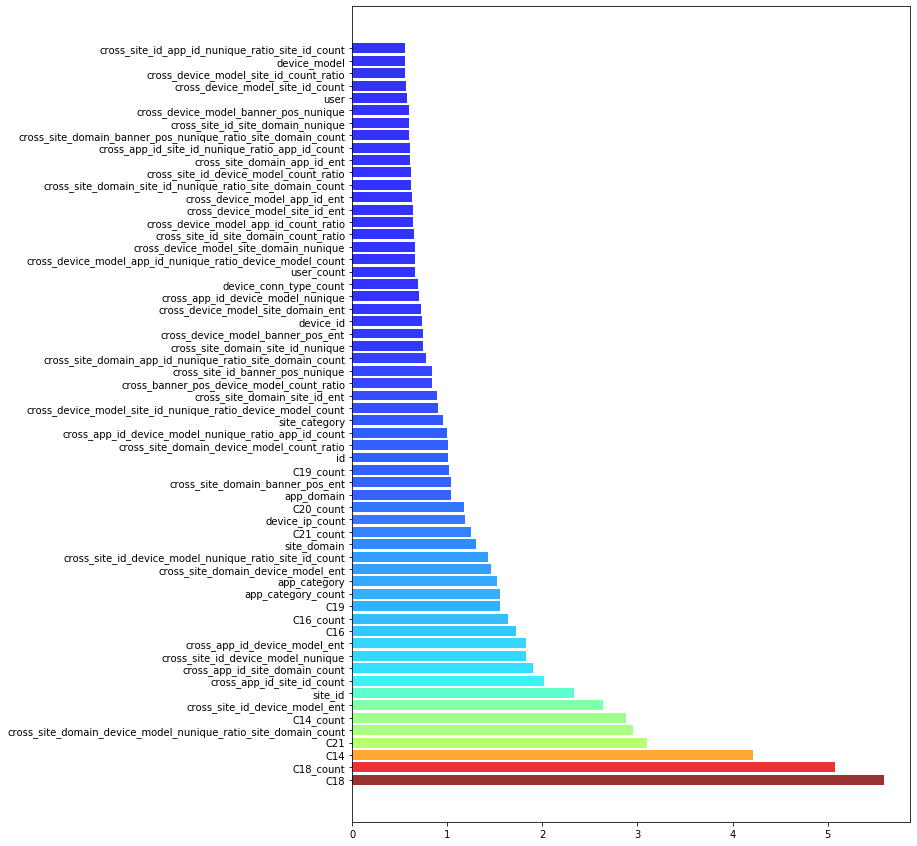

In [11]:
import matplotlib.pyplot as plt 
from matplotlib import cm
imp_score = pd.DataFrame()
imp_score['fea_name'] = clf.feature_names_
imp_score['fea']=clf.feature_importances_
imp_score = imp_score.sort_values(['fea'], ascending=False)
temp = pd.DataFrame()
temp = imp_score[:60]
color = cm.jet(temp['fea']/temp['fea'].max())
plt.figure(figsize=(10, 15))
plt.barh(temp['fea_name'],temp['fea'],height =0.8,color=color,alpha=0.8)
plt.show()